In [128]:
import joblib
import csv
import pandas as pd
import glob
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd

from sklearn.decomposition import PCA
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio import features
from collections import defaultdict

from skimage import filters, morphology

In [129]:
# Reload the trained model
model_path = "rf_classifier_model31DEC.pkl"
rf = joblib.load(model_path)
print(f"Model loaded from {model_path}")

Model loaded from rf_classifier_model31DEC.pkl


In [130]:
# Set paths to image directory and list all images
year = "2019"
image_dir = rf"C:\Users\WilsonSIRL5-MCY-E113\Documents\White glacier ML\WhiteSentinel2file_{year}"
image_files = glob.glob(os.path.join(image_dir, "*.tif"))

glacier_outline = gpd.read_file(r"C:\Users\WilsonSIRL5-MCY-E113\Documents\White glacier ML\White outline\glims_polygons.shp")

# Load the DEM
dem_path = r"C:\Users\WilsonSIRL5-MCY-E113\Documents\White glacier ML\whiteglacierDEM_reprojected.tif"

In [131]:
pca = PCA(n_components=2)

# Classify a new image using the trained Random Forest model
def classify_image(image_path, model, pca_transformer):
    # Read the new image using Rasterio
    with rasterio.open(image_path) as img:
        r = img.read(1)
        g = img.read(2)
        b = img.read(3)
        ir = img.read(4)

    # Stack bands into a single array
    stacked = np.dstack((r, g, b, ir)).reshape((-1, 4))

    # Apply PCA transformation
    stacked_pca = pca.fit_transform(stacked)

    # Predict labels for the new image
    predicted_labels = model.predict(stacked_pca)
    
    # Reshape to original image shape
    label_img = predicted_labels.reshape(img.height, img.width)
    
    return label_img

In [132]:
# Function to classify image and calculate SCR
def classify_and_calculate_scr(image_path, model, pca_transformer):
    # Classify the image
    classified_image = classify_image(image_path, model, pca_transformer)

    # Count the classified pixels for snow, ice, and ground
    unique, counts = np.unique(classified_image, return_counts=True)
    pixel_counts = dict(zip(unique, counts))

    # Each pixel represents a 10m x 10m area (100 square meters)
    pixel_area = 100  # in square meters

    # Calculate areal extent
    ice_area = pixel_counts.get(2, 0) * pixel_area  # Assuming 2 is ice
    snow_area = (pixel_counts.get(1, 0) * pixel_area) + (pixel_counts.get(3, 0) * pixel_area) # Assuming 1 +3 is snow

    total_area = ice_area + snow_area

    # Calculate Snow Cover Ratio (SCR)
    scr = snow_area / total_area if total_area != 0 else 0

    return classified_image, scr


In [133]:
# Create a CSV file to store the results
output_csv_file = rf"{year}_glacier_classification_summary.csv"

with open(output_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Date", "Ice Area (km²)", "Snow Area (km²)", "Ground Area (km²)", "Snow Cover Ratio (SCR)"])
    
    for img_path in image_files:
        # Extract the date from the filename
        file_name = os.path.basename(img_path)
        date_str = file_name.split('_')[1].split('(')[0]

        # Classify the image and calculate SCR
        classified_image, scr = classify_and_calculate_scr(img_path, rf, pca)

        # Count the classified pixels for snow, ice, and ground
        unique, counts = np.unique(classified_image, return_counts=True)
        pixel_counts = dict(zip(unique, counts))

        # Each pixel represents a 10m x 10m area (100 square meters)
        pixel_area = 100  # in square meters

        # Calculate areal extent
        ice_area = pixel_counts.get(2, 0) * pixel_area  # Assuming 2 is ice
        snow_area = (pixel_counts.get(1, 0) * pixel_area) + (pixel_counts.get(3, 0) * pixel_area) # Assuming 1 + 3 is snow
        ground_area = pixel_counts.get(0, 0) * pixel_area  # Assuming 0 is ground

        # Write results to CSV
        writer.writerow([date_str, ice_area / 1e6, snow_area / 1e6, ground_area / 1e6, scr])

print(f"Results saved to {output_csv_file}")

Results saved to 2019_glacier_classification_summary.csv


In [134]:
# Find the image with the lowest SCR
lowest_scr = float('inf')
lowest_scr_image_path = None
lowest_scr_image = None

for img_path in image_files:
    _, scr = classify_and_calculate_scr(img_path, rf, pca)
    if scr < lowest_scr:
        lowest_scr = scr
        lowest_scr_image_path = img_path

# Process the image with the lowest SCR
classified_image, _ = classify_and_calculate_scr(lowest_scr_image_path, rf, pca)

# Extract the date and SCR value for the lowest SCR image
lowest_scr_date = pd.to_datetime(os.path.basename(lowest_scr_image_path).split("_")[1].split(".")[0].split("(")[0], format='%Y-%m-%d', errors='coerce')

lowest_scr_value = lowest_scr

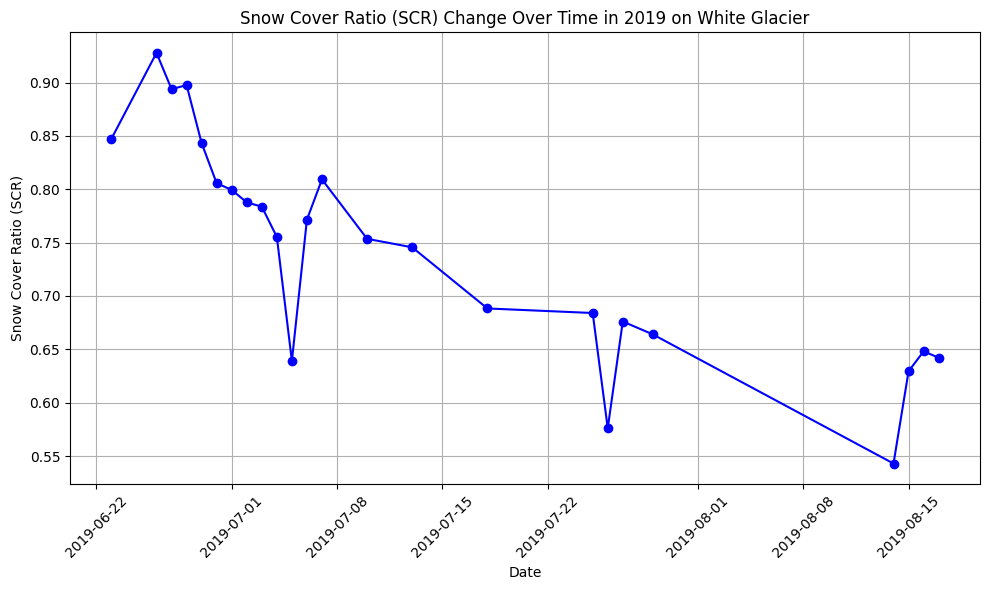

In [135]:
# Assuming results is a list of tuples with (date_str, scr)
results = []

for img_path in image_files:
    # Extract the date from the filename
    file_name = os.path.basename(img_path)
    date_str = file_name.split('_')[1].split('.')[0]

    # Classify the image and calculate SCR
    _, scr = classify_and_calculate_scr(img_path, rf, pca)

    # Append the date and SCR to the results list
    results.append((date_str, scr))

# Visualize the SCR change by date
results_df = pd.DataFrame(results, columns=["Date", "SCR"])
results_df["Date"] = pd.to_datetime(results_df["Date"], format='%Y-%m-%d', errors='coerce')
results_df = results_df.dropna().sort_values(by="Date")

plt.figure(figsize=(10, 6))
plt.plot(results_df["Date"], results_df["SCR"], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Snow Cover Ratio (SCR)')
plt.title(f'Snow Cover Ratio (SCR) Change Over Time in {year} on White Glacier')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

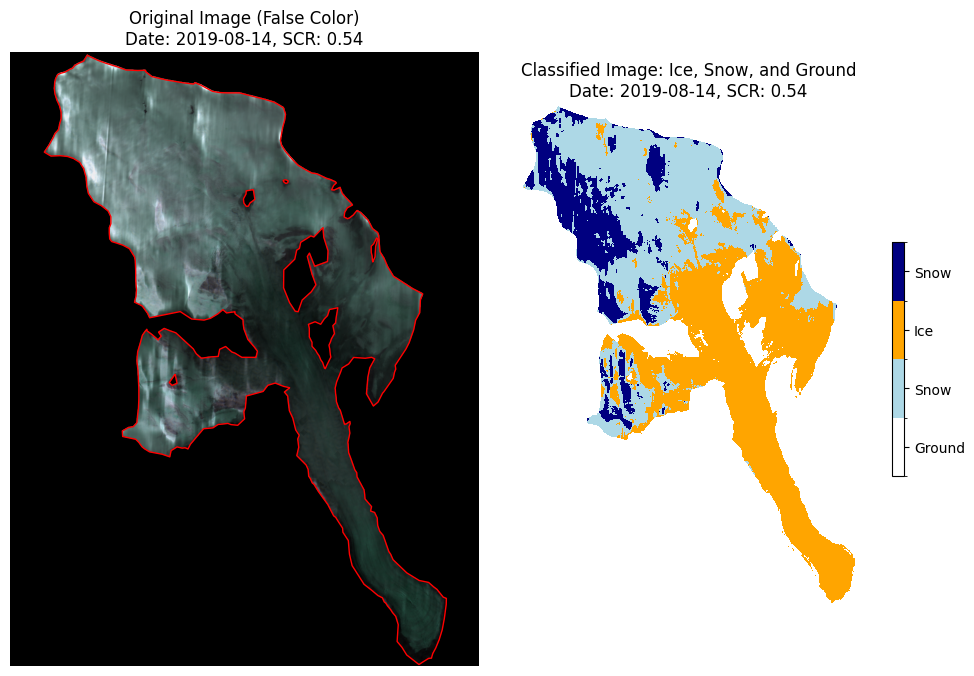

In [136]:
# Open and read the original image with the lowest SCR
with rasterio.open(lowest_scr_image_path) as src:
    band_1 = src.read(1)  # Blue
    band_2 = src.read(2)  # Green
    band_3 = src.read(3)  # Red
    band_4 = src.read(4)  # Near-Infrared
    sentinel_crs = src.crs
    sentinel_extent = src.bounds

# Stack the bands to create an RGB image
false_color = np.dstack((band_4, band_2, band_3))

# Normalize to enhance visualization (0-255 scale)
false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min()) * 255
false_color = false_color.astype(np.uint8)

# Load the glacier outline shapefile and reproject to match the Sentinel-2 image CRS
glacier_outline = glacier_outline.to_crs(sentinel_crs)

# Set the extent to match the Sentinel-2 image bounds
extent = [sentinel_extent.left, sentinel_extent.right, sentinel_extent.bottom, sentinel_extent.top]

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 12))

# Plot the original image with glacier outline
im1 = axes[0].imshow(false_color, extent=extent)
glacier_outline.plot(ax=axes[0], facecolor='none', edgecolor='red', linewidth=1, zorder=2)
axes[0].set_title(f'Original Image (False Color)\nDate: {lowest_scr_date.date()}, SCR: {lowest_scr_value:.2f}', fontsize=12)
axes[0].axis('off')

# Plot the classified image with glacier outline
im2 = axes[1].imshow(classified_image, cmap='viridis', extent=extent)
glacier_outline.plot(ax=axes[1], facecolor='none', edgecolor='red', linewidth=1, zorder=2)
axes[1].set_title(f'Classified Image: Ice, Snow, and Ground\nDate: {lowest_scr_date.date()}, SCR: {lowest_scr_value:.2f}', fontsize=12)
axes[1].axis('off')

# Plot the classified image with elevation bins on the second subplot
cmap = mcolors.ListedColormap(['white', 'lightblue', 'orange', 'navy'])
bounds = [0, 1, 2, 3, 4]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
im = axes[1].imshow(classified_image, cmap=cmap, interpolation='none', norm=norm)

# Add a colorbar with clear labels
cbar = plt.colorbar(im, ax=axes[1], boundaries=bounds, ticks=[0.5, 1.5, 2.5, 3.5], shrink=0.2, pad=0.02)
cbar.ax.set_yticklabels(['Ground', 'Snow', 'Ice', 'Snow'], fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [137]:
# Open and read the DEM
with rasterio.open(dem_path) as dem:
    dem_data = dem.read(1)
    dem_meta = dem.meta

# Extract metadata from the original image used for classification
with rasterio.open(lowest_scr_image_path) as src:
    classified_meta = src.meta

# Check that the DEM and classified image align
if (classified_meta['height'], classified_meta['width']) != (dem_meta['height'], dem_meta['width']):
    # Reproject the DEM to match the classified image
    transform, width, height = calculate_default_transform(
        dem.crs, classified_meta['crs'], classified_meta['width'], classified_meta['height'], *src.bounds
    )
    dem_meta.update({
        'crs': classified_meta['crs'],
        'transform': transform,
        'width': width,
        'height': height
    })

    reprojected_dem = np.empty((height, width), dtype=np.float32)

    with rasterio.open(dem_path) as src:
        reproject(
            source=rasterio.band(src, 1),
            destination=reprojected_dem,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=classified_meta['crs'],
            resampling=Resampling.bilinear
        )
    dem_data = reprojected_dem

# Set the elevation bins (every 20 meters)
elevation_min = np.floor(dem_data.min() / 20) * 20
elevation_max = np.ceil(dem_data.max() / 20) * 20
elevation_bins = np.arange(elevation_min, elevation_max + 20, 20)

# Calculate the SCR (Snow Cover Ratio) in each elevation bin
scr_results = defaultdict(float)
for i in range(len(elevation_bins) - 1):
    lower_bound = elevation_bins[i]
    upper_bound = elevation_bins[i + 1]

    # Create a mask for the current elevation bin
    elevation_mask = (dem_data >= lower_bound) & (dem_data < upper_bound)
    classified_in_bin = classified_image[elevation_mask]

    # Calculate the SCR (assumed that snow is classified as value 1 and 3, and ice/land as other)
    if classified_in_bin.size > 0:
        snow_pixels = np.sum(classified_in_bin == 1) + np.sum(classified_in_bin == 3)
        total_pixels = snow_pixels + np.sum(classified_in_bin == 2)
        scr_results[f"{lower_bound}-{upper_bound}m"] = snow_pixels / total_pixels

# Convert the SCR results to a DataFrame for easier analysis and visualization
scr_df = pd.DataFrame(list(scr_results.items()), columns=['Elevation_Bin', 'Snow_Cover_Ratio'])
print(scr_df)


# Show the bins with SCR over 0.5
high_scr_bins = scr_df[scr_df['Snow_Cover_Ratio'] > 0.5]
print("Bins with SCR over 0.5:")
print(high_scr_bins)


     Elevation_Bin  Snow_Cover_Ratio
0        0.0-20.0m               NaN
1       20.0-40.0m               NaN
2       40.0-60.0m               NaN
3       60.0-80.0m               NaN
4      80.0-100.0m               NaN
..             ...               ...
84  1680.0-1700.0m          0.950787
85  1700.0-1720.0m          0.953771
86  1720.0-1740.0m          0.922705
87  1740.0-1760.0m          1.000000
88  1760.0-1780.0m          1.000000

[89 rows x 2 columns]
Bins with SCR over 0.5:
     Elevation_Bin  Snow_Cover_Ratio
57  1140.0-1160.0m          0.592137
58  1160.0-1180.0m          0.689461
59  1180.0-1200.0m          0.698292
60  1200.0-1220.0m          0.734409
61  1220.0-1240.0m          0.745084
62  1240.0-1260.0m          0.808867
63  1260.0-1280.0m          0.879494
64  1280.0-1300.0m          0.855753
65  1300.0-1320.0m          0.875901
66  1320.0-1340.0m          0.894096
67  1340.0-1360.0m          0.906909
68  1360.0-1380.0m          0.909105
69  1380.0-1400.0m          

C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_23416\2913318486.py:56: RuntimeWarning: invalid value encountered in scalar divide
  scr_results[f"{lower_bound}-{upper_bound}m"] = snow_pixels / total_pixels


Text(0.5, 1.02, 'White Glacier Snowline Analysis in 2019')

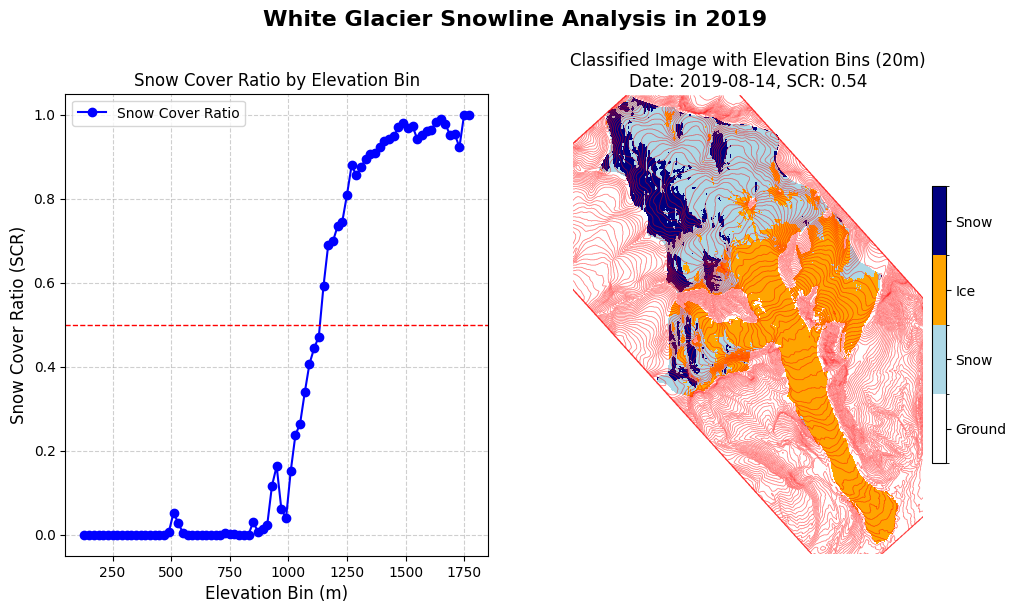

In [138]:
# Prepare the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Extract the numeric range from Elevation_Bin for plotting
scr_df['Elevation_Mid'] = scr_df['Elevation_Bin'].apply(
    lambda x: (float(x.split('-')[0]) + float(x.split('-')[1][:-1])) / 2
)

# Plot the Snow Cover Ratio vs Elevation on the first subplot
ax1.plot(scr_df['Elevation_Mid'], scr_df['Snow_Cover_Ratio'], marker='o', linestyle='-', color='blue', label='Snow Cover Ratio')
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
ax1.set_xlabel('Elevation Bin (m)', fontsize=12)
ax1.set_ylabel('Snow Cover Ratio (SCR)', fontsize=12)
ax1.set_title('Snow Cover Ratio by Elevation Bin', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=10)

# Plot the classified image with elevation bins on the second subplot
cmap = mcolors.ListedColormap(['white', 'lightblue', 'orange', 'navy'])
bounds = [0, 1, 2, 3, 4]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
im = ax2.imshow(classified_image, cmap=cmap, interpolation='none', norm=norm)

# Add a colorbar with clear labels
cbar = plt.colorbar(im, ax=ax2, boundaries=bounds, ticks=[0.5, 1.5, 2.5, 3.5], shrink=0.6, pad=0.02)
cbar.ax.set_yticklabels(['Ground', 'Snow', 'Ice', 'Snow'], fontsize=10)


# Add elevation contours for visualization
for i in range(len(elevation_bins) - 1):
    lower_bound = elevation_bins[i]
    upper_bound = elevation_bins[i + 1]
    elevation_mask = (dem_data >= lower_bound) & (dem_data < upper_bound)
    ax2.contour(elevation_mask, levels=[0.5], colors=['red'], linewidths=0.5, alpha=0.3)

# Remove axis ticks for the image subplot
ax2.axis('off')
ax2.set_title(f'Classified Image with Elevation Bins (20m)\nDate: {lowest_scr_date.date()}, SCR: {lowest_scr_value:.2f}', fontsize=12)

# Add a main title for the figure
fig.suptitle(f'White Glacier Snowline Analysis in {lowest_scr_date.year}', fontsize=16, fontweight='bold', y=1.02)

In [139]:
# Define pixel values for snow and ice
snow_classes = [1, 3]  # Replace with actual snow classification values
ice_classes = [2]      # Replace with actual ice classification values
ground_classes = [0]   # Ground class

# Create masks for snow and ice
snow_mask = np.isin(classified_image, snow_classes)
ice_mask = np.isin(classified_image, ice_classes)

# Find the snow-ice boundary
snow_ice_boundary = snow_mask & morphology.binary_dilation(ice_mask, morphology.disk(1))

In [140]:
# Create a glacier mask (snow + ice, excluding ground)
glacier_mask = (np.isin(classified_image, snow_classes + ice_classes)) & (~np.isin(classified_image, ground_classes))

# Erode the glacier mask to exclude edges
glacier_core = morphology.binary_erosion(glacier_mask, morphology.disk(10))  # Adjust the buffer size

# Refine the snow-ice boundary to exclude glacier edges
refined_snow_ice_boundary = snow_ice_boundary & glacier_core

In [141]:
from skimage.measure import label, regionprops

# Label connected regions in the boundary
labeled_boundary = label(refined_snow_ice_boundary)

# Filter regions based on size
filtered_boundary = np.zeros_like(labeled_boundary, dtype=bool)
for region in regionprops(labeled_boundary):
    if region.area > 100:  # Keep regions larger than 100 pixels
        filtered_boundary[labeled_boundary == region.label] = True

In [142]:
# Extract elevations for the refined boundary
boundary_elevations = dem_data[filtered_boundary]

# Remove invalid values (e.g., NaN)
boundary_elevations = boundary_elevations[~np.isnan(boundary_elevations)]

In [143]:
# Compute statistics
average_elevation = np.mean(boundary_elevations)
median_elevation = np.median(boundary_elevations)
std_elevation = np.std(boundary_elevations)

# Find the highest frequency and the related elevation
hist, bin_edges = np.histogram(boundary_elevations, bins=np.arange(boundary_elevations.min(), boundary_elevations.max() + 10, 10))
bin_size = bin_edges[1] - bin_edges[0]
print(f"Bin size: {bin_size}")
max_freq_index = np.argmax(hist)
max_freq_elevation = (bin_edges[max_freq_index] + bin_edges[max_freq_index + 1]) / 2

print(f"Average Snow Line Elevation: {average_elevation:.2f} m")
print(f"Median Elevation: {median_elevation:.2f} m")
print(f"Standard Deviation: {std_elevation:.2f} m")
print(f"Highest Frequency: {hist[max_freq_index]} at Elevation: {max_freq_elevation:.2f} m")

Bin size: 10.0
Average Snow Line Elevation: 1167.95 m
Median Elevation: 1145.80 m
Standard Deviation: 141.93 m
Highest Frequency: 192 at Elevation: 1046.90 m


C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_23416\582933348.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  boundary_contour = axes[1].contour(filtered_boundary, levels=[0.5], colors='red', linewidths=1.5, label="Snow-Ice Boundary")
C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_23416\582933348.py:30: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  axes[1].legend([boundary_contour.collections[0]], ['Snow-Ice Boundary'], fontsize=12, loc='upper right')


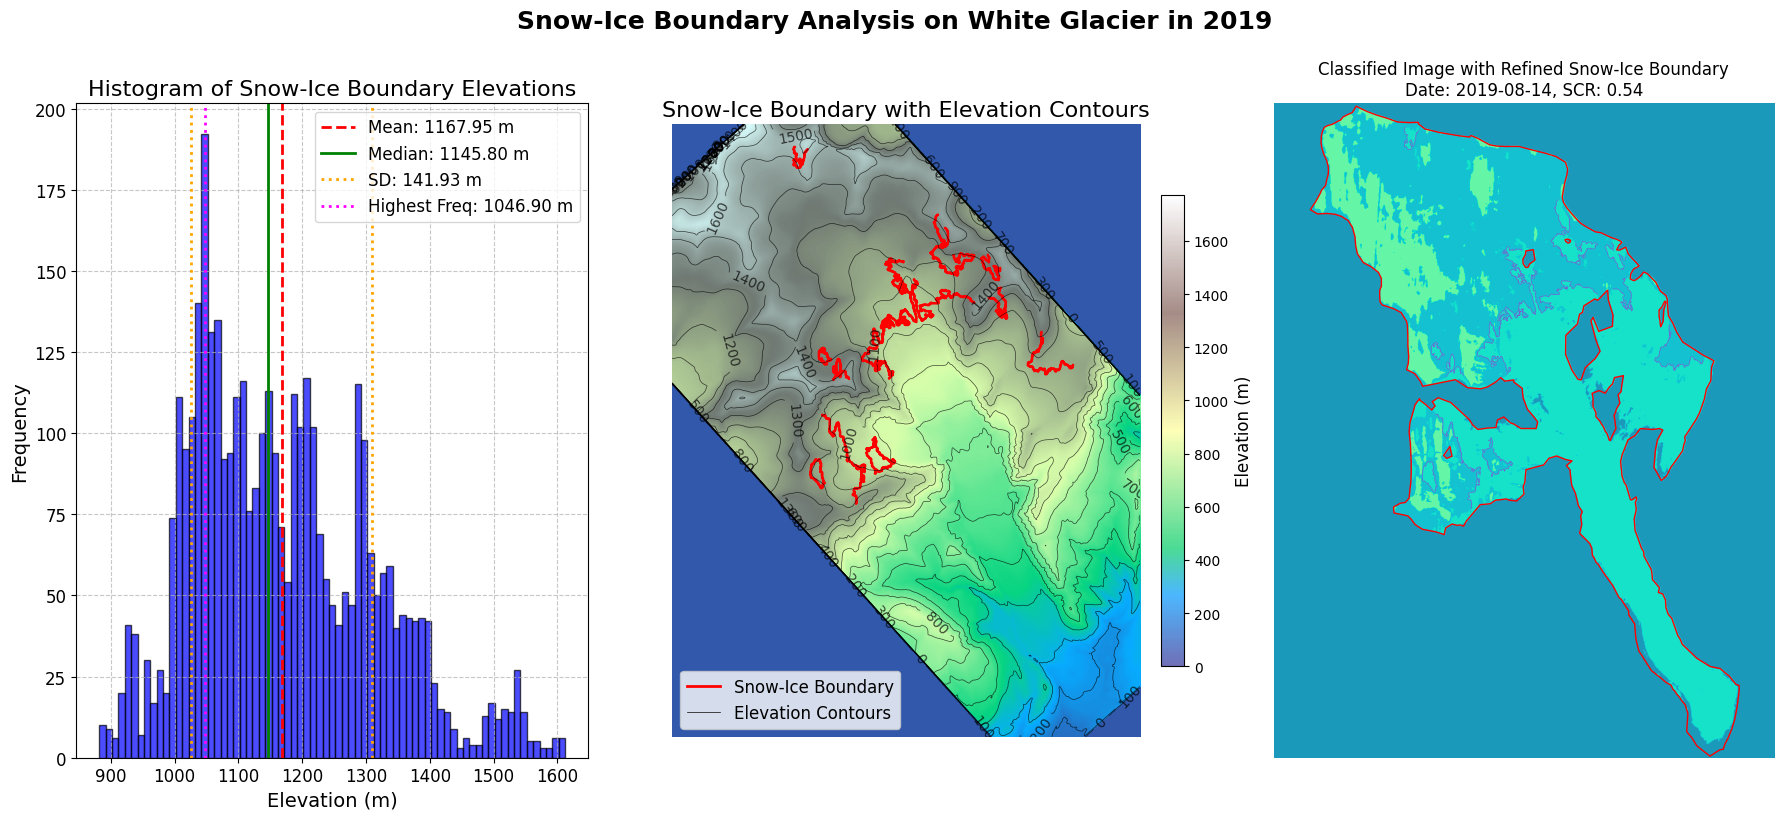

In [144]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Plot the histogram of snow-ice boundary elevations on the first subplot
axes[0].hist(boundary_elevations, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7)
axes[0].axvline(average_elevation, color='r', linestyle='--', linewidth=2, label=f'Mean: {average_elevation:.2f} m')
axes[0].axvline(median_elevation, color='g', linestyle='-', linewidth=2, label=f'Median: {median_elevation:.2f} m')
axes[0].axvline(average_elevation + std_elevation, color='orange', linestyle=':', linewidth=2, label=f'SD: {std_elevation:.2f} m')
axes[0].axvline(average_elevation - std_elevation, color='orange', linestyle=':', linewidth=2)
axes[0].axvline(max_freq_elevation, color='magenta', linestyle=':', linewidth=2, label=f'Highest Freq: {max_freq_elevation:.2f} m')
axes[0].set_xlabel('Elevation (m)', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].set_title('Histogram of Snow-Ice Boundary Elevations', fontsize=16)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].legend(fontsize=12)

# Plot the snow-ice boundary map on the second subplot
axes[1].imshow(dem_data, cmap='terrain', alpha=0.8)
axes[1].imshow(filtered_boundary, cmap='cool', alpha=0.5)
axes[1].set_title("Snow-Ice Boundary with Elevation Contours", fontsize=16)
axes[1].axis('off')

# Add a colorbar for the DEM data
cbar = fig.colorbar(axes[1].imshow(dem_data, cmap='terrain', alpha=0.7), ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04, shrink=0.8)
cbar.set_label('Elevation (m)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Highlight the boundary with a thicker line
boundary_contour = axes[1].contour(filtered_boundary, levels=[0.5], colors='red', linewidths=1.5, label="Snow-Ice Boundary")
axes[1].legend([boundary_contour.collections[0]], ['Snow-Ice Boundary'], fontsize=12, loc='upper right')

# Add contour lines for the DEM data
contour = axes[1].contour(dem_data, levels=20, colors='black', linewidths=0.5, alpha=0.7)
axes[1].clabel(contour, inline=True, fontsize=10, fmt='%1.0f', colors='black')

# Add a legend for clarity
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='Snow-Ice Boundary'),
    plt.Line2D([0], [0], color='black', lw=0.5, label='Elevation Contours')
]
axes[1].legend(handles=legend_elements, fontsize=12, loc='lower left')


# Plot the classified image with the refined snow-ice boundary on the third subplot
im = axes[2].imshow(classified_image, cmap='viridis', extent=extent)
glacier_outline.plot(ax=axes[2], facecolor='none', edgecolor='r', zorder=2)
axes[2].imshow(filtered_boundary, cmap='cool', alpha=0.6, extent=extent)
axes[2].set_title(f'Classified Image with Refined Snow-Ice Boundary\nDate: {lowest_scr_date.date()}, SCR: {lowest_scr_value:.2f}')
axes[2].axis('off')

# Add a title for the entire figure
plt.suptitle(f'Snow-Ice Boundary Analysis on White Glacier in {lowest_scr_date.year}', fontsize=18, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()


In [145]:
# Check the CRS of the snow and ice boundary
boundary_crs = glacier_outline.crs
print(f"Snow and Ice Boundary CRS: {boundary_crs}")

# Check the CRS of the classified image
classified_image_crs = classified_meta['crs']
print(f"Classified Image CRS: {classified_image_crs}")

# Verify if both CRS are the same
if boundary_crs == classified_image_crs:
    print("The CRS of the snow and ice boundary and the classified image are the same.")
else:
    print("The CRS of the snow and ice boundary and the classified image are different.")

Snow and Ice Boundary CRS: PROJCS["WGS 84 / UTM zone 16N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32616"]]
Classified Image CRS: EPSG:32616
The CRS of the snow and ice boundary and the classified image are the same.


In [146]:
# Display the classified image as the base layer
im = axes[2].imshow(classified_image, cmap='viridis', extent=extent)

# Plot the glacier outline as a red edge overlay
glacier_outline.plot(ax=axes[2], facecolor='none', edgecolor='r', zorder=2)

# Overlay the filtered boundary with transparency
axes[2].imshow(filtered_boundary, cmap='cool', alpha=0.6, extent=extent, zorder=3)

# Add title with date and SCR value
axes[2].set_title(f'Classified Image with Refined Snow-Ice Boundary\nDate: {lowest_scr_date.date()}, SCR: {lowest_scr_value:.2f}')

# Remove axis for clean display
axes[2].axis('off')


(416778.9333620985, 426728.9333620985, 8820259.541422334, 8833279.541422334)

<Figure size 640x480 with 0 Axes>

In [147]:
# Define acceptable elevation range for the primary snowline
elevation_min = 900  # Lower bound for snowline

# Filter the boundary elevations to exclude outliers
filtered_elevations = boundary_elevations[
    (boundary_elevations >= elevation_min) 
]

# Create a mask for elevations below 900m
elevation_mask_below_900 = dem_data < elevation_min

# Remove the boundary below 900m
filtered_boundary[elevation_mask_below_900] = False

In [148]:
# Compute statistics
average_elevation = np.mean(filtered_elevations)
median_elevation = np.median(filtered_elevations)
std_elevation = np.std(filtered_elevations)

# Find the highest frequency and the related elevation
hist, bin_edges = np.histogram(filtered_elevations, bins=np.arange(filtered_elevations.min(), filtered_elevations.max() + 5, 5))
bin_size = bin_edges[1] - bin_edges[0]
print(f"Bin size: {bin_size}")
max_freq_index = np.argmax(hist)
max_freq_elevation = (bin_edges[max_freq_index] + bin_edges[max_freq_index + 1]) / 2

print(f"Average Snow Line Elevation: {average_elevation:.2f} m")
print(f"Median Elevation: {median_elevation:.2f} m")
print(f"Standard Deviation: {std_elevation:.2f} m")
print(f"Highest Frequency: {hist[max_freq_index]} at Elevation: {max_freq_elevation:.2f} m")

Bin size: 5.0
Average Snow Line Elevation: 1169.18 m
Median Elevation: 1146.44 m
Standard Deviation: 141.04 m
Highest Frequency: 107 at Elevation: 1043.08 m


C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_23416\3702888184.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  boundary_contour = axes[1].contour(filtered_boundary, levels=[0.5], colors='red', linewidths=1.5, label="Snow-Ice Boundary")
C:\Users\WilsonSIRL5-MCY-E113\AppData\Local\Temp\ipykernel_23416\3702888184.py:30: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  axes[1].legend([boundary_contour.collections[0]], ['Snow-Ice Boundary'], fontsize=12, loc='upper right')


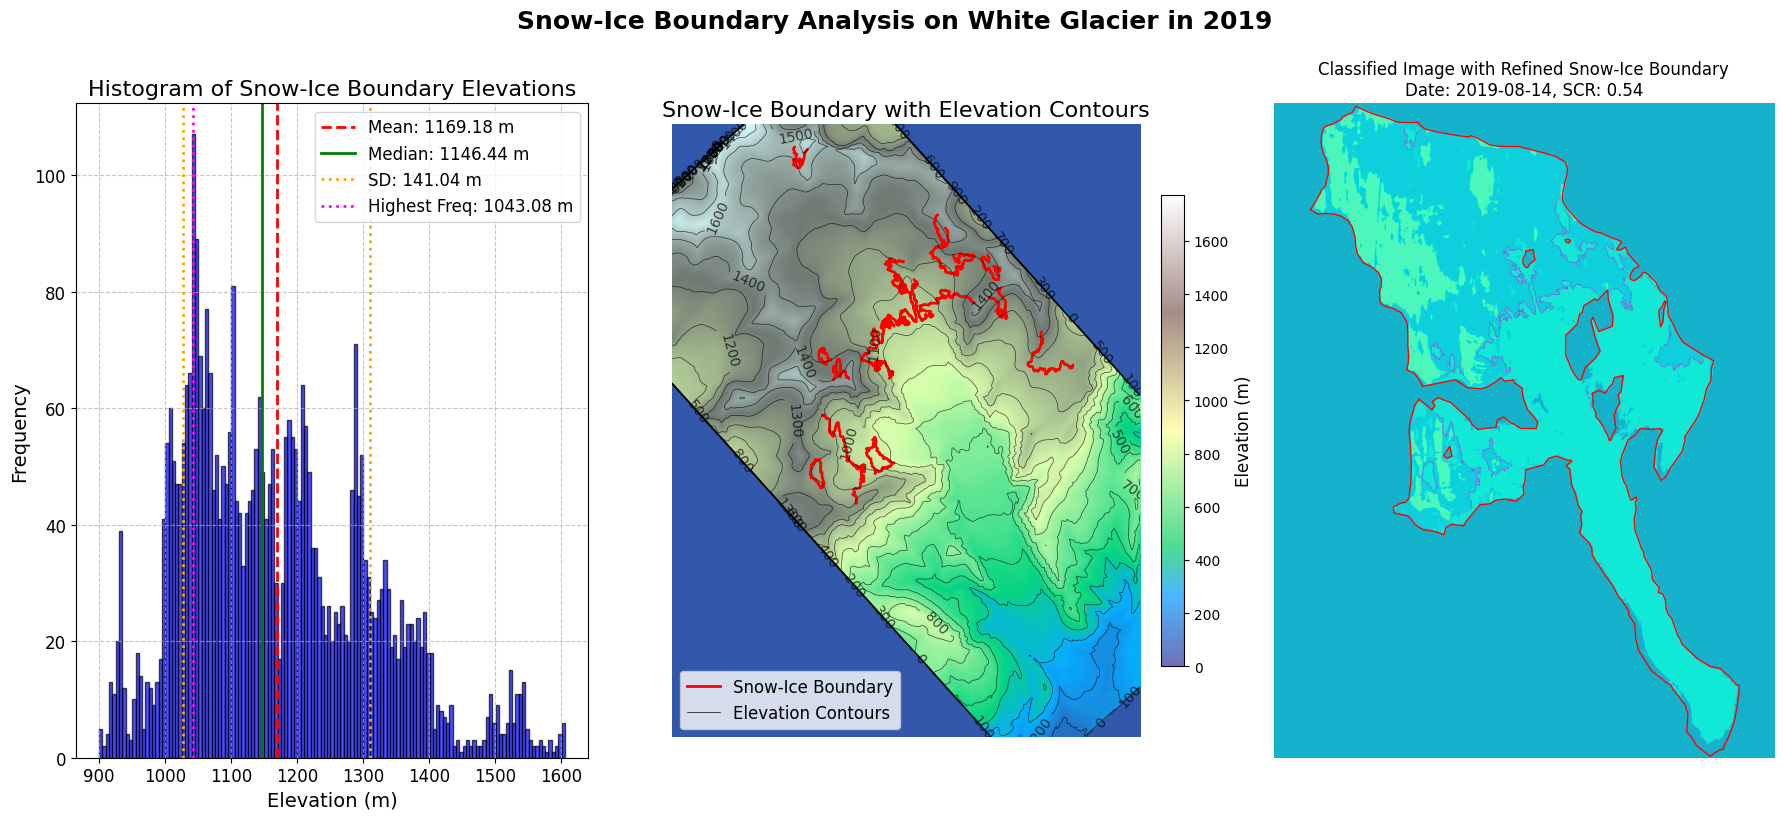

In [149]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Plot the histogram of snow-ice boundary elevations on the first subplot
axes[0].hist(filtered_elevations, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7)
axes[0].axvline(average_elevation, color='r', linestyle='--', linewidth=2, label=f'Mean: {average_elevation:.2f} m')
axes[0].axvline(median_elevation, color='g', linestyle='-', linewidth=2, label=f'Median: {median_elevation:.2f} m')
axes[0].axvline(average_elevation + std_elevation, color='orange', linestyle=':', linewidth=2, label=f'SD: {std_elevation:.2f} m')
axes[0].axvline(average_elevation - std_elevation, color='orange', linestyle=':', linewidth=2)
axes[0].axvline(max_freq_elevation, color='magenta', linestyle=':', linewidth=2, label=f'Highest Freq: {max_freq_elevation:.2f} m')
axes[0].set_xlabel('Elevation (m)', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].set_title('Histogram of Snow-Ice Boundary Elevations', fontsize=16)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].legend(fontsize=12)

# Plot the snow-ice boundary map on the second subplot
axes[1].imshow(dem_data, cmap='terrain', alpha=0.8)
axes[1].imshow(filtered_boundary, cmap='cool', alpha=0.5)
axes[1].set_title("Snow-Ice Boundary with Elevation Contours", fontsize=16)
axes[1].axis('off')

# Add a colorbar for the DEM data
cbar = fig.colorbar(axes[1].imshow(dem_data, cmap='terrain', alpha=0.7), ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04, shrink=0.8)
cbar.set_label('Elevation (m)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Highlight the boundary with a thicker line
boundary_contour = axes[1].contour(filtered_boundary, levels=[0.5], colors='red', linewidths=1.5, label="Snow-Ice Boundary")
axes[1].legend([boundary_contour.collections[0]], ['Snow-Ice Boundary'], fontsize=12, loc='upper right')

# Add contour lines for the DEM data
contour = axes[1].contour(dem_data, levels=20, colors='black', linewidths=0.5, alpha=0.7)
axes[1].clabel(contour, inline=True, fontsize=10, fmt='%1.0f', colors='black')

# Add a legend for clarity
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='Snow-Ice Boundary'),
    plt.Line2D([0], [0], color='black', lw=0.5, label='Elevation Contours')
]
axes[1].legend(handles=legend_elements, fontsize=12, loc='lower left')


# Classified image with the refined snow-ice boundary
axes[2].imshow(classified_image, cmap='viridis', extent=extent)
glacier_outline.plot(ax=axes[2], facecolor='none', edgecolor='r', zorder=2)
axes[2].imshow(filtered_boundary, cmap='cool', alpha=0.7, extent=extent)
axes[2].set_title(f'Classified Image with Refined Snow-Ice Boundary\nDate: {lowest_scr_date.date()}, SCR: {lowest_scr_value:.2f}')
axes[2].axis('off')

# Add a title for the entire figure
plt.suptitle(f'Snow-Ice Boundary Analysis on White Glacier in {lowest_scr_date.year}', fontsize=18, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()


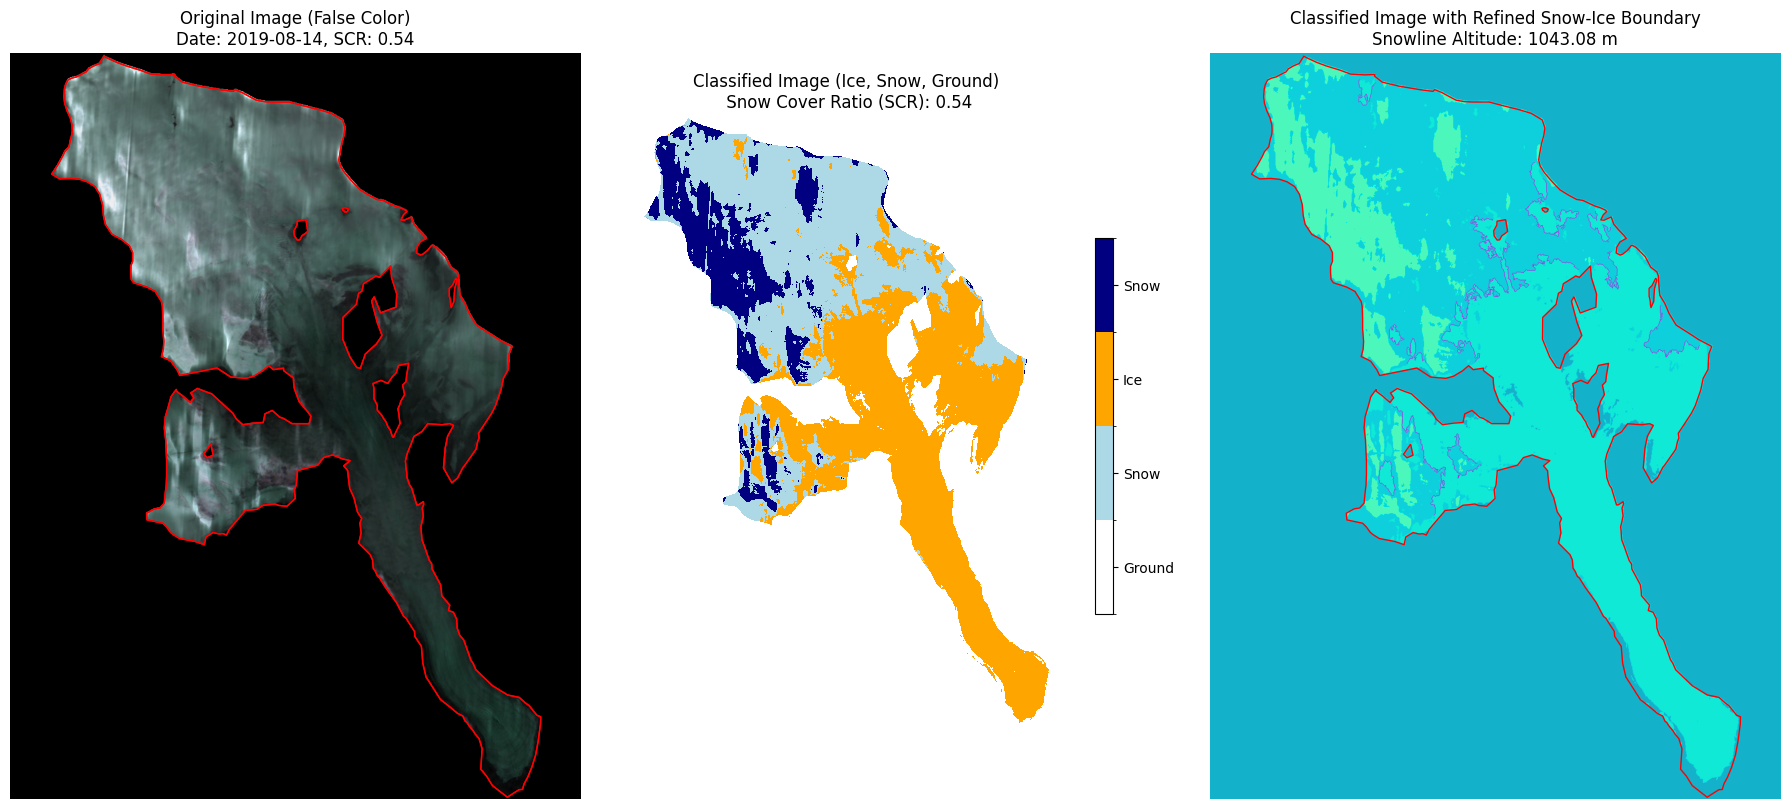

In [150]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Original image with glacier outline (False Color for better ice and snow distinction)
axes[0].imshow(false_color, extent=extent)
glacier_outline.plot(ax=axes[0], facecolor='none', edgecolor='r', zorder=2)
axes[0].set_title(f'Original Image (False Color)\nDate: {lowest_scr_date.date()}', fontsize=12)
axes[0].axis('off')

# Plot the original image with glacier outline
im1 = axes[0].imshow(false_color, extent=extent)
glacier_outline.plot(ax=axes[0], facecolor='none', edgecolor='red', linewidth=1, zorder=2)
axes[0].set_title(f'Original Image (False Color)\nDate: {lowest_scr_date.date()}, SCR: {lowest_scr_value:.2f}', fontsize=12)
axes[0].axis('off')

# Plot the classified image with glacier outline
im2 = axes[1].imshow(classified_image, cmap='viridis', extent=extent)
glacier_outline.plot(ax=axes[1], facecolor='none', edgecolor='red', linewidth=1, zorder=2)
axes[1].set_title(f'Classified Image (Ice, Snow, Ground)\n Snow Cover Ratio (SCR): {lowest_scr_value:.2f}', fontsize=12)
axes[1].axis('off')

# Plot the classified image with elevation bins on the second subplot
cmap = mcolors.ListedColormap(['white', 'lightblue', 'orange', 'navy'])
bounds = [0, 1, 2, 3, 4]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
im = axes[1].imshow(classified_image, cmap=cmap, interpolation='none', norm=norm)

# Add a colorbar with clear labels
cbar = plt.colorbar(im, ax=axes[1], boundaries=bounds, ticks=[0.5, 1.5, 2.5, 3.5], shrink=0.5, pad=0.02)
cbar.ax.set_yticklabels(['Ground', 'Snow', 'Ice', 'Snow'], fontsize=10)

# Classified image with the refined snow-ice boundary
axes[2].imshow(classified_image, cmap='viridis', extent=extent)
glacier_outline.plot(ax=axes[2], facecolor='none', edgecolor='r', zorder=2)
axes[2].imshow(filtered_boundary, cmap='cool', alpha=0.7, extent=extent)
axes[2].set_title(f'Classified Image with Refined Snow-Ice Boundary\nSnowline Altitude: {max_freq_elevation:.2f} m', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

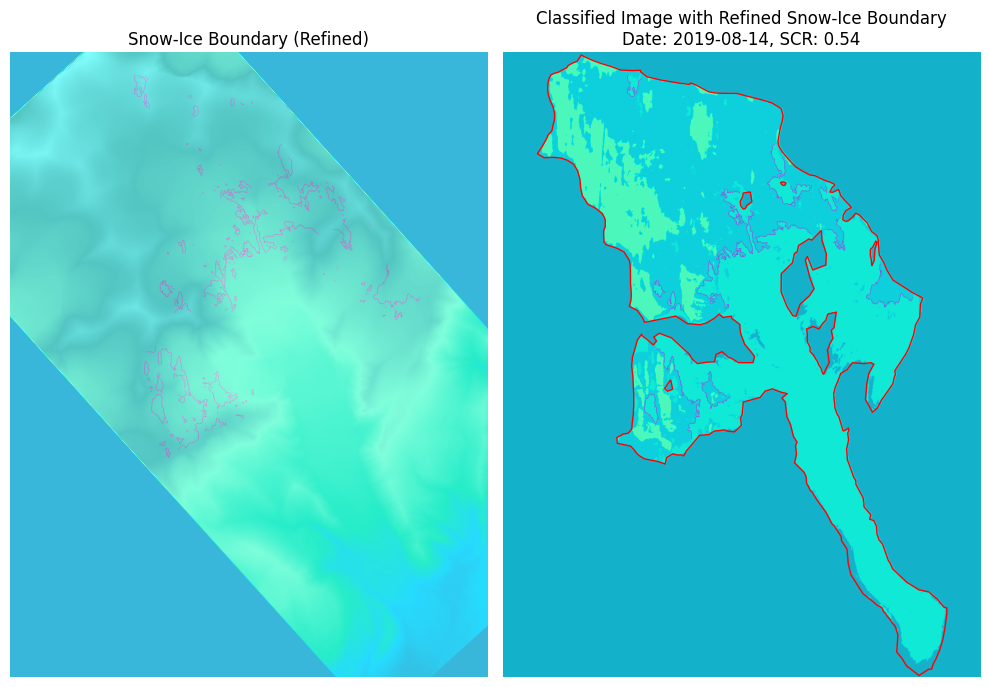

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

# Plot the DEM with the refined snow-ice boundary on the first subplot
ax1.imshow(dem_data, cmap='terrain', alpha=0.7)
ax1.imshow(refined_snow_ice_boundary, cmap='cool', alpha=0.5)
ax1.set_title("Snow-Ice Boundary (Refined)")
ax1.axis('off')

# Plot the classified image on the second subplot with the refined snow-ice boundary
ax2.imshow(classified_image, cmap='viridis', extent=extent)
glacier_outline.plot(ax=ax2, facecolor='none', edgecolor='r', zorder=2)
ax2.imshow(filtered_boundary, cmap='cool', alpha=0.7, extent=extent)
ax2.set_title(f'Classified Image with Refined Snow-Ice Boundary\nDate: {lowest_scr_date.date()}, SCR: {lowest_scr_value:.2f}')
ax2.axis('off')

plt.tight_layout()
plt.show()
